In [328]:
import json
import os

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sn
from shapely.geometry import Point, LineString
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

tqdm.pandas()

In [329]:
pd.options.display.max_columns = None

# Data loading

### Kornel

In [330]:
# Kornel
data = pd.read_excel('../../data/raw/Ankiety.xlsx', "Wrocław_ankiety+podróże", engine='openpyxl', header=[0,1])
data.columns = [f'{i}_{j}' for i, j in data.columns]
data = data.iloc[0:14241]

### Marcel

In [331]:
# # Marcel
# kbr_data_path = '../../data/raw/KBR/'
# kbr_dir_path = '1_Ankiety_w_gospodarstwach_domowych/'
# kbr_file_path = 'Etap_V_1_1_Ankiety_w_gospodarstwach_domowych_Wroclaw.xlsx'
# excel_sheet = 'Wrocław_ankiety+podróże'

# data = pd.read_excel(os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path), excel_sheet, header=[0,1], engine='openpyxl')

# data.columns = [f'{i}_{j}' for i, j in data.columns]
# data = data.iloc[0:14241]

# if data.shape[1] == len(set(list(data.columns))):
#     print('All column names are unique.')
# else:
#     print('All column names are NOT unique.')

In [332]:
kr_processed_data_path = '../../data/processed/kr'
kr_processed_file_path = 'distance_between_regions.json'

with open(os.path.join(kr_processed_data_path, kr_processed_file_path), 'r') as f:
    distance_between_regions = json.load(f)

In [333]:
data.head()

,Lp_Lp,IDENTYFIKACJA ANKIETY_ID_LOS (numer kwestionariusza),IDENTYFIKACJA ANKIETY_Nr ankietera,IDENTYFIKACJA ANKIETY_Data wypełnienia kwestionariusza,IDENTYFIKACJA ANKIETY_Godzina wypełnienia kwestionariusza,IDENTYFIKACJA ANKIETY_Nr rejonu komunikacyjnego,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Wprowadzenie opłat za wjazd do centrum dla wszystkich pojazdów,"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dopuszczenie dojazdu do centrum dla pojazdów, które nie zanieczyszczają środowiska (np. pojazdy elektryczne, hybrydowe lub spełniające najwyższe normy spalania)","PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jaka jest Pana/Pani opinia na temat rozwiązań wspierających kursowanie tramwajów i autobusów, takich jak priorytet przejazdu na skrzyżowaniach oraz wydzielone pasy na jezdniach?",PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Z jakiego środka transportu zbiorowego korzysta Pan/Pani najczęściej?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dlaczego? \n[tramwaj/autobus],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dlaczego? [Inne]\n[tramwaj/autobus],"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jaka jest Pana/Pani opinia na temat rozwoju systemu kolei aglomeracyjnej na terenie Wrocławia i wokół niego (rozbudowa układu torowego, zwiększenie częstotliwości itd.)?",PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia czystość taboru komunikacji zbiorowej we Wrocławiu?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niekorzystne ustawienia sygnalizacji świetlnej],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zły stan nawierzchni chodników],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zastawianie chodników przez parkujące samochody],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niebezpieczne zachowania kierowców],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zagrożenie ze strony rowerzystów poruszających się chodnikami],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zbyt wysokie krawężniki],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak bieżącego utrzymania czystości/odśnieżania],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewystarczająca liczba przejść dla pieszych],"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wska

In [334]:
chosen_cols = [
    # 'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Z jakiego środka transportu zbiorowego korzysta Pan/Pani\xa0najczęściej?',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?\xa0',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia\xa0punktualność\xa0komunikacji zbiorowej\xa0we Wrocławiu?\xa0',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i\xa0parkingów rowerowych)?',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niekorzystne ustawienia sygnalizacji świetlnej]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zły stan nawierzchni chodników]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zastawianie chodników przez parkujące samochody]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niebezpieczne zachowania kierowców]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zagrożenie ze strony rowerzystów poruszających się chodnikami]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zbyt wysokie krawężniki]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak bieżącego utrzymania czystości/odśnieżania]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewystarczająca liczba przejść dla pieszych]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [uciążliwy ruch kołowy]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewłaściwe oświetlenie ciągów pieszych]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba osób w gospodarstwie domowym [ogółem]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód prywatny, zarejestrowany na osobę z gosp. domowego]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód służbowy]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Rower]',
    'DANE O RESPONDENCIE_Przedział wiekowy',
    'DANE O RESPONDENCIE_Płeć',
    # 'DANE O RESPONDENCIE_Zajęcie podstawowe',
    'DANE O RESPONDENCIE_Kondycja fizyczna',
    'DANE O RESPONDENCIE_Opieka nad innymi osobami',
    'DANE O RESPONDENCIE_Posiadanie prawa jazdy kat. B',
    'DANE O RESPONDENCIE_Posiadanie biletu okresowego',
    'DANE O RESPONDENCIE_Posiadanie ulgi na przejazd komunikacją zbiorową we Wrocławiu',
    'OPIS PODRÓŻY "ŹRÓDŁO"_Z jakiego miejsca',
    'OPIS PODRÓŻY "ŹRÓDŁO"_Nr rejonu',
    'OPIS PODRÓŻY "CEL"_Do jakiego miejsca',
    'OPIS PODRÓŻY "CEL"_Nr rejonu',
    '23:59:00_pora dnia',
    '23:59:00_motywacje',
    '23:59:00_środek transportu grupa'
]

data = data[chosen_cols]

data.columns = [
    # 'Z jakiego środka transportu zbiorowego korzysta Pan/Pani najczęściej?',
    'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?',
    'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?',
    'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?',
    'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej',
    'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką',
    'PIESZO Zły stan nawierzchni chodników',
    'PIESZO Zastawianie chodników przez parkujące samochody',
    'PIESZO Niebezpieczne zachowania kierowców',
    'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami',
    'PIESZO Zbyt wysokie krawężniki',
    'PIESZO Brak bieżącego utrzymania czystości/odśnieżania',
    'PIESZO Niewystarczająca liczba przejść dla pieszych',
    'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)',
    'PIESZO Uciążliwy ruch kołowy',
    'PIESZO Niewłaściwe oświetlenie ciągów pieszych',
    'Liczba osób w gospodarstwie domowym [ogółem]',
    'Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]',
    'Samochód prywatny, zarejestrowany na osobę z gosp. domowego',
    'Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]',
    'Samochód służbowy',
    'Liczba rowerów w gosp. dom.',
    'Przedział wiekowy',
    'Płeć',
    # 'Zajęcie podstawowe',
    'Kondycja fizyczna',
    'Opieka nad innymi osobami',
    'Posiadanie prawa jazdy kat. B',
    'Posiadanie biletu okresowego',
    'Posiadanie ulgi na przejazd komunikację zbiorową',
    'ŹRÓDŁO Z jakiego miejsca',
    'ŹRÓDŁO Nr rejonu',
    'CEL Do jakiego miejsca',
    'CEL Nr rejonu',
    'Pora dnia (godzina)',
    'Motywacje (skąd-dokąd)',
    'Środek transportu grupa'
]

In [335]:
data.head()

,Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PIESZO Niekorzystne ustawienia sygnalizacji świetlnej,PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką,PIESZO Zły stan nawierzchni chodników,PIESZO Zastawianie chodników przez parkujące samochody,PIESZO Niebezpieczne zachowania kierowców,PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami,PIESZO Zbyt wysokie krawężniki,PIESZO Brak bieżącego utrzymania czystości/odśnieżania,PIESZO Niewystarczająca liczba przejść dla pieszych,"PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)",PIESZO Uciążliwy ruch kołowy,PIESZO Niewłaściwe oświetlenie ciągów pieszych,Liczba osób w gospodarstwie domowym [ogółem],Liczba osób w gospodarstwie domowym [powyżej 6 roku życia],"Samochód prywatny, zarejestrowany na osobę z gosp. domowego","Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]",Samochód służbowy,Liczba rowerów w gosp. dom.,Przedział wiekowy,Płeć,Kondycja fizyczna,Opieka nad innymi osobami,Posiadanie prawa jazdy kat. B,Posiadanie biletu okresowego,Posiadanie ulgi na przejazd komunikację zbiorową,ŹRÓDŁO Z jakiego miejsca,ŹRÓDŁO Nr rejonu,CEL Do jakiego miejsca,CEL Nr rejonu,Pora dnia (godzina),Motywacje (skąd-dokąd),Środek transportu grupa
0,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,0.0,0.0,0.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,dom,67.0,Inne,68.0,9:00-9:59,dom-Inne,komunikacja samochodowa
1,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,0.0,0.0,0.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,Inne,68.0,dom,67.0,9:00-9:59,Inne-dom,komunikacja samochodowa
2,bardzo dobrze,raczej dobrze,raczej dobrze,Nie,Nie,Nie,Tak,Nie,Nie,Nie,Nie,Tak,Nie,Nie,Nie,2.0,2.0,0.0,1.0,0.0,1.0,20-24 (wiek studencki),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN
3,bardzo dobrze,raczej dobrze,raczej dobrze,Nie,Nie,Nie,Tak,Nie,Nie,Nie,Nie,Tak,Nie,Nie,Nie,2.0,2.0,0.0,1.0,0.0,1.0,20-24 (wiek studencki),Mężczyzna,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN
4,bardzo dobrze,bardzo dobrze,ani dobrze ani źle,Nie,Tak,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,2.0,2.0,1.0,0.0,0.0,0.0,61 i więcej (emeryci kobiety),Kobieta,dolegliwości zdrowotne,nie dotyczy,Nie,Nie,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN


In [336]:
data.shape

(14241, 35)

# Data processing

## Drop rows with NaN values and prepare column 'Samochód'

In [337]:
data = data.dropna()

data['Liczba aut w gosp. dom.'] = data['Samochód prywatny, zarejestrowany na osobę z gosp. domowego'] + data['Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]'] + data['Samochód służbowy']

data = data.drop(columns=['Samochód prywatny, zarejestrowany na osobę z gosp. domowego', 'Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]', 'Samochód służbowy'])

data.shape

(10626, 33)

## Add column with the dsitance of the trip

In [338]:
regions_unique = distance_between_regions.keys()

data = data[
    (data['ŹRÓDŁO Nr rejonu'].astype('int').astype('str').isin(regions_unique)) &
    (data['CEL Nr rejonu'].astype('int').astype('str').isin(regions_unique))
]

In [339]:
def add_regions_num(row):
    row['Przebyta odległość'] = distance_between_regions[str(int(row['ŹRÓDŁO Nr rejonu']))][str(int(row['CEL Nr rejonu']))]

    return row


data = data.progress_apply(add_regions_num, axis=1)

100%|██████████| 10138/10138 [00:08<00:00, 1172.32it/s]


## Add column with age_sex_comb

In [340]:
data['age_bracket'] = data['Przedział wiekowy']
data['sex'] = data['Płeć']

In [341]:
age_bracket_map_dict = {
    '6-15 (dzieci)': '6-15',
    '16-19 (młodzież)': '16-19',
    '20-24 (wiek studencki)': '20-24',
    '25-44 (młodsi pracownicy)': '25-44',
    '45-60 (starsi pracownicy kobiety)': '45-60',  # '45-60(K)',
    '45-65 (starsi pracownicy mężczyźni)': '45-65',  # '45-65(M)',
    '61 i więcej (emeryci kobiety)': '61-x',  # '61-(K)',
    '66 i więcej (emeryci mężczyźni)': '66-x'  # '66-(M)'
}
data.replace({'age_bracket': age_bracket_map_dict}, inplace=True)

sex_map_dict = {
    'Kobieta': 'K',
    'Mężczyzna': 'M'
}
data.replace({'sex': sex_map_dict}, inplace=True)

data['age_sex_comb'] = data['age_bracket'] + '_' + data['sex']

In [342]:
data = data.drop(columns=['age_bracket', 'sex'], axis=1)

In [343]:
data_copy = data

In [344]:
data.head()

,Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PIESZO Niekorzystne ustawienia sygnalizacji świetlnej,PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką,PIESZO Zły stan nawierzchni chodników,PIESZO Zastawianie chodników przez parkujące samochody,PIESZO Niebezpieczne zachowania kierowców,PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami,PIESZO Zbyt wysokie krawężniki,PIESZO Brak bieżącego utrzymania czystości/odśnieżania,PIESZO Niewystarczająca liczba przejść dla pieszych,"PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)",PIESZO Uciążliwy ruch kołowy,PIESZO Niewłaściwe oświetlenie ciągów pieszych,Liczba osób w gospodarstwie domowym [ogółem],Liczba osób w gospodarstwie domowym [powyżej 6 roku życia],Liczba rowerów w gosp. dom.,Przedział wiekowy,Płeć,Kondycja fizyczna,Opieka nad innymi osobami,Posiadanie prawa jazdy kat. B,Posiadanie biletu okresowego,Posiadanie ulgi na przejazd komunikację zbiorową,ŹRÓDŁO Z jakiego miejsca,ŹRÓDŁO Nr rejonu,CEL Do jakiego miejsca,CEL Nr rejonu,Pora dnia (godzina),Motywacje (skąd-dokąd),Środek transportu grupa,Liczba aut w gosp. dom.,Przebyta odległość,age_sex_comb
0,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,dom,67.0,Inne,68.0,9:00-9:59,dom-Inne,komunikacja samochodowa,0.0,1223.212986,61-x_K
1,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,Inne,68.0,dom,67.0,9:00-9:59,Inne-dom,komunikacja samochodowa,0.0,1223.212986,61-x_K
5,bardzo dobrze,bardzo dobrze,bardzo dobrze,Nie,Tak,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,2.0,2.0,0.0,45-65 (starsi pracownicy mężczyźni),Mężczyzna,dobry stan zdrowia,nie dotyczy,Tak,Nie,0.5,dom,67.0,Inne,68.0,9:00-9:59,dom-Inne,komunikacja samochodowa,1.0,1223.212986,45-65_M
6,bardzo dobrze,bardzo dobrze,bardzo dobrze,Nie,Tak,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,2.0,2.0,0.0,45-65 (starsi pracownicy mężczyźni),Mężczyzna,dobry stan zdrowia,nie dotyczy,Tak,Nie,0.5,Inne,68.0,dom,67.0,9:00-9:59,Inne-dom,komunikacja samochodowa,1.0,1223.212986,45-65_M
7,bardzo dobrze,raczej dobrze,nie korzystam z systemu dróg i parkingów rower...,Nie,Nie,Nie,Nie,Tak,Nie,Nie,Nie,Nie,Nie,Nie,Nie,1.0,1.0,0.0,25-44 (młodsi pracownicy),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,dom,67.0,Inne,29.0,18:00-18:59,dom-Inne,komunikacja zbiorowa,0.0,2637.323757,25-44_K


## Features dataframe processing - map string values to numerical

### 'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?'

In [345]:
data['Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?'].unique()

array(['bardzo dobrze', 'raczej dobrze',
       'nie korzystam z komunikacji zbiorowej', 'raczej źle',
       'ani dobrze ani źle', 'bardzo źle'], dtype=object)

In [346]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?': var_map_dict}, inplace=True)

### 'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?'

In [347]:
data['Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?'].unique()

array(['raczej dobrze', 'bardzo dobrze', 'raczej źle',
       'ani dobrze ani źle', 'nie korzystam z komunikacji zbiorowej',
       'bardzo źle'], dtype=object)

In [348]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?': var_map_dict}, inplace=True)

### 'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?'

In [349]:
data['Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?'].unique()

array(['bardzo dobrze',
       'nie korzystam z systemu dróg i parkingów rowerowych',
       'raczej źle', 'raczej dobrze', 'ani dobrze ani źle', 'bardzo źle',
       'nie korzystam z komunikacji zbiorowej'], dtype=object)

In [350]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'nie korzystam z systemu dróg i parkingów rowerowych': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?': var_map_dict}, inplace=True)

### 'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej'

In [351]:
data['PIESZO Niekorzystne ustawienia sygnalizacji świetlnej'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [352]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej': var_map_dict}, inplace=True)

### 'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką'

In [353]:
data['PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [354]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką': var_map_dict}, inplace=True)

### 'PIESZO Zły stan nawierzchni chodników'

In [355]:
data['PIESZO Zły stan nawierzchni chodników'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [356]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zły stan nawierzchni chodników': var_map_dict}, inplace=True)

### PIESZO Zastawianie chodników przez parkujące samochody

In [357]:
data['PIESZO Zastawianie chodników przez parkujące samochody'].unique()

array(['Nie', 'Tak', 'tak', 'nie'], dtype=object)

In [358]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zastawianie chodników przez parkujące samochody': var_map_dict}, inplace=True)

### PIESZO Niebezpieczne zachowania kierowców

In [359]:
data['PIESZO Niebezpieczne zachowania kierowców'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [360]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niebezpieczne zachowania kierowców': var_map_dict}, inplace=True)

### 'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami'

In [361]:
data['PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [362]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami': var_map_dict}, inplace=True)

### 'PIESZO Zbyt wysokie krawężniki'

In [363]:
data['PIESZO Zbyt wysokie krawężniki'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [364]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zbyt wysokie krawężniki': var_map_dict}, inplace=True)

### 'PIESZO Brak bieżącego utrzymania czystości/odśnieżania'

In [365]:
data['PIESZO Brak bieżącego utrzymania czystości/odśnieżania'].unique()

array(['Nie', 'Tak', 'tak', 'nie'], dtype=object)

In [366]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak bieżącego utrzymania czystości/odśnieżania': var_map_dict}, inplace=True)

### 'PIESZO Niewystarczająca liczba przejść dla pieszych'

In [367]:
data['PIESZO Niewystarczająca liczba przejść dla pieszych'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [368]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niewystarczająca liczba przejść dla pieszych': var_map_dict}, inplace=True)

### 'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)'

In [369]:
data['PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [370]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)': var_map_dict}, inplace=True)

### 'PIESZO Uciążliwy ruch kołowy'

In [371]:
data['PIESZO Uciążliwy ruch kołowy'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [372]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Uciążliwy ruch kołowy': var_map_dict}, inplace=True)

### 'PIESZO Niewłaściwe oświetlenie ciągów pieszych'

In [373]:
data['PIESZO Niewłaściwe oświetlenie ciągów pieszych'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [374]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niewłaściwe oświetlenie ciągów pieszych': var_map_dict}, inplace=True)

### 'Przedział wiekowy'

In [375]:
data['Przedział wiekowy'].unique()

array(['61 i więcej (emeryci kobiety)',
       '45-65 (starsi pracownicy mężczyźni)', '25-44 (młodsi pracownicy)',
       '66 i więcej (emeryci mężczyźni)',
       '45-60 (starsi pracownicy kobiety)', '20-24 (wiek studencki)',
       '16-19 (młodzież)', '6-15 (dzieci)'], dtype=object)

In [376]:
var_map_dict = {
    '6-15 (dzieci)': 0,
    '16-19 (młodzież)': 1,
    '20-24 (wiek studencki)': 2,
    '25-44 (młodsi pracownicy)': 3,
    '45-60 (starsi pracownicy kobiety)': 4,
    '45-65 (starsi pracownicy mężczyźni)': 4,
    '61 i więcej (emeryci kobiety)': 5,
    '66 i więcej (emeryci mężczyźni)': 5
}

data.replace({'Przedział wiekowy': var_map_dict}, inplace=True)

### 'Płeć'

In [377]:
data['Płeć'].unique()

array(['Kobieta', 'Mężczyzna'], dtype=object)

In [378]:
var_map_dict = {
    'Mężczyzna': 0,
    'Kobieta': 1
}

data.replace({'Płeć': var_map_dict}, inplace=True)

### 'Kondycja fizyczna'

In [379]:
data['Kondycja fizyczna'].unique()

array(['dobry stan zdrowia',
       'osoba starsza dolegliwości związane z\xa0wiekiem',
       'kłopoty z poruszaniem się', 'dolegliwości zdrowotne', 'Inne',
       'inne'], dtype=object)

In [380]:
var_map_dict = {
    'kłopoty z poruszaniem się': 0,
    'dolegliwości zdrowotne': 0,
    'osoba starsza dolegliwości związane z\xa0wiekiem': 0,
    'Inne': 0,
    'inne': 0,
    'dobry stan zdrowia': 1
}

data.replace({'Kondycja fizyczna': var_map_dict}, inplace=True)

### 'Opieka nad innymi osobami'

In [381]:
data['Opieka nad innymi osobami'].unique()

array(['nie dotyczy', 'opieka nad dzieckiem',
       'opieka nad osobą w podeszłym wieku', 'opieka nad inną osobą'],
      dtype=object)

In [382]:
var_map_dict = {
    'nie dotyczy': 0,
    'opieka nad dzieckiem': 1,
    'opieka nad osobą w podeszłym wieku': 1,
    'opieka nad inną osobą': 1
}

data.replace({'Opieka nad innymi osobami': var_map_dict}, inplace=True)

### 'Posiadanie prawa jazdy kat. B'

In [383]:
data['Posiadanie prawa jazdy kat. B'].unique()

array(['Tak', 'Nie', 'tak'], dtype=object)

In [384]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'Posiadanie prawa jazdy kat. B': var_map_dict}, inplace=True)

### 'Posiadanie biletu okresowego'

In [385]:
data['Posiadanie biletu okresowego'].unique()

array(['Tak', 'Nie', 'tak'], dtype=object)

In [386]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'Posiadanie biletu okresowego': var_map_dict}, inplace=True)

### 'Posiadanie ulgi na przejazd komunikację zbiorową'

In [387]:
data['Posiadanie ulgi na przejazd komunikację zbiorową'].unique()

array([0.5, 1, 'brak ulgi'], dtype=object)

In [388]:
var_map_dict = {
    'brak ulgi': 0,
    0.5: 0.5,
    1: 1,
}

data.replace({'Posiadanie ulgi na przejazd komunikację zbiorową': var_map_dict}, inplace=True)

### 'Pora dnia (godzina)'

In [389]:
sorted(data['Pora dnia (godzina)'].unique())

['0:00-4:59',
 '10:00-10:59',
 '11:00-11:59',
 '12:00-12:59',
 '13:00-13:59',
 '14:00-14:59',
 '15:00-15:59',
 '16:00-16:59',
 '17:00-17:59',
 '18:00-18:59',
 '19:00-19:59',
 '20:00-23:59',
 '5:00-5:59',
 '6:00-6:59',
 '7:00-7:59',
 '8:00-8:59',
 '9:00-9:59']

In [390]:
var_map_dict = {
    '0:00-4:59': 0,         # noc           0-5
    '5:00-5:59': 1,         # rano          5-10
    '6:00-6:59': 1,         # rano          5-10
    '7:00-7:59': 1,         # rano          5-10
    '8:00-8:59': 1,         # rano          5-10
    '9:00-9:59': 1,         # rano          5-10
    '10:00-10:59': 2,       # południe      10-14
    '11:00-11:59': 2,       # południe      10-14
    '12:00-12:59': 2,       # południe      10-14
    '13:00-13:59': 2,       # południe      10-14
    '14:00-14:59': 3,       # popołudnie    14-19
    '15:00-15:59': 3,       # popołudnie    14-19
    '16:00-16:59': 3,       # popołudnie    14-19
    '17:00-17:59': 3,       # popołudnie    14-19
    '18:00-18:59': 3,       # popołudnie    14-19
    '19:00-19:59': 4,       # wieczór       19-0
    '20:00-23:59': 4        # wieczór       19-0
}

data.replace({'Pora dnia (godzina)': var_map_dict}, inplace=True)

### 'Środek transportu grupa'

In [391]:
data['Środek transportu grupa'].unique()

array(['komunikacja samochodowa', 'komunikacja zbiorowa', 'pieszo',
       'rower', 'inne'], dtype=object)

In [392]:
data['Środek transportu grupa'].value_counts()

komunikacja samochodowa    3605
komunikacja zbiorowa       2976
pieszo                     2752
rower                       742
inne                         63
Name: Środek transportu grupa, dtype: int64

In [393]:
drop_inne = True

if drop_inne:
    data = data[data['Środek transportu grupa'] != 'inne']
    var_map_dict = {
        'komunikacja samochodowa': 'komunikacja samochodowa',
        'komunikacja zbiorowa': 'komunikacja zbiorowa',
        'pieszo': 'pieszo',
        'rower': 'rower',
    }
else:
    var_map_dict = {
        'komunikacja samochodowa': 0,
        'komunikacja zbiorowa': 1,
        'pieszo': 2,
        'rower': 3,
        'inne': 4
    }

data.replace({'Środek transportu grupa': var_map_dict}, inplace=True)

### 'CEL Do jakiego miejsca'

In [394]:
data['CEL Do jakiego miejsca'] = data['CEL Do jakiego miejsca'].str.replace('Inne', 'inne')
sorted(data['CEL Do jakiego miejsca'].unique())

['dom', 'inne', 'praca', 'szkoła', 'uczelnia']

In [395]:
data = data.merge(
    pd.get_dummies(data['CEL Do jakiego miejsca'], prefix='CEL'),
    left_index=True, 
    right_index=True
)

## Save data dataframe

In [396]:
out_dir = '../../data/processed/mc/decission_tree'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_file = 'data_2.csv'
out_path = os.path.join(out_dir, out_file)

out_path

'../../data/processed/mc/decission_tree/data_2.csv'

In [397]:
data.to_csv(out_path)

In [398]:
data = pd.read_csv(out_path, index_col = 0)

# Decision Tree

In [399]:
data.head()

,Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PIESZO Niekorzystne ustawienia sygnalizacji świetlnej,PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką,PIESZO Zły stan nawierzchni chodników,PIESZO Zastawianie chodników przez parkujące samochody,PIESZO Niebezpieczne zachowania kierowców,PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami,PIESZO Zbyt wysokie krawężniki,PIESZO Brak bieżącego utrzymania czystości/odśnieżania,PIESZO Niewystarczająca liczba przejść dla pieszych,"PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)",PIESZO Uciążliwy ruch kołowy,PIESZO Niewłaściwe oświetlenie ciągów pieszych,Liczba osób w gospodarstwie domowym [ogółem],Liczba osób w gospodarstwie domowym [powyżej 6 roku życia],Liczba rowerów w gosp. dom.,Przedział wiekowy,Płeć,Kondycja fizyczna,Opieka nad innymi osobami,Posiadanie prawa jazdy kat. B,Posiadanie biletu okresowego,Posiadanie ulgi na przejazd komunikację zbiorową,ŹRÓDŁO Z jakiego miejsca,ŹRÓDŁO Nr rejonu,CEL Do jakiego miejsca,CEL Nr rejonu,Pora dnia (godzina),Motywacje (skąd-dokąd),Środek transportu grupa,Liczba aut w gosp. dom.,Przebyta odległość,age_sex_comb,CEL_dom,CEL_inne,CEL_praca,CEL_szkoła,CEL_uczelnia
0,4,3,4,0,0,0,0,0,1,1,0,0,0,1,0,1.0,1.0,1.0,5,1,1,0,1,1,0.5,dom,67.0,inne,68.0,1,dom-Inne,komunikacja samochodowa,0.0,1223.212986,61-x_K,0,1,0,0,0
1,4,3,4,0,0,0,0,0,1,1,0,0,0,1,0,1.0,1.0,1.0,5,1,1,0,1,1,0.5,Inne,68.0,dom,67.0,1,Inne-dom,komunikacja samochodowa,0.0,1223.212986,61-x_K,1,0,0,0,0
5,4,4,4,0,1,0,0,0,0,0,0,0,0,0,0,2.0,2.0,0.0,4,0,1,0,1,0,0.5,dom,67.0,inne,68.0,1,dom-Inne,komunikacja samochodowa,1.0,1223.212986,45-65_M,0,1,0,0,0
6,4,4,4,0,1,0,0,0,0,0,0,0,0,0,0,2.0,2.0,0.0,4,0,1,0,1,0,0.5,Inne,68.0,dom,67.0,1,Inne-dom,komunikacja samochodowa,1.0,1223.212986,45-65_M,1,0,0,0,0
7,4,3,2,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,3,1,1,0,1,1,0.5,dom,67.0,inne,29.0,3,dom-Inne,komunikacja zbiorowa,0.0,2637.323757,25-44_K,0,1,0,0,0


In [400]:
X = data.drop(columns=['Środek transportu grupa', 'ŹRÓDŁO Z jakiego miejsca', 'ŹRÓDŁO Nr rejonu', 'CEL Do jakiego miejsca', 'CEL Nr rejonu', 'Motywacje (skąd-dokąd)', 'age_sex_comb'])
y = data['Środek transportu grupa']

## All features, max_depth=None

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [402]:
data['Środek transportu grupa'].value_counts()

komunikacja samochodowa    3605
komunikacja zbiorowa       2976
pieszo                     2752
rower                       742
Name: Środek transportu grupa, dtype: int64

In [403]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

komunikacja samochodowa       0.81      0.82      0.81      1178
   komunikacja zbiorowa       0.78      0.76      0.77       994
                 pieszo       0.81      0.79      0.80       895
                  rower       0.56      0.62      0.59       258

               accuracy                           0.78      3325
              macro avg       0.74      0.75      0.74      3325
           weighted avg       0.78      0.78      0.78      3325



### Confusion matrix

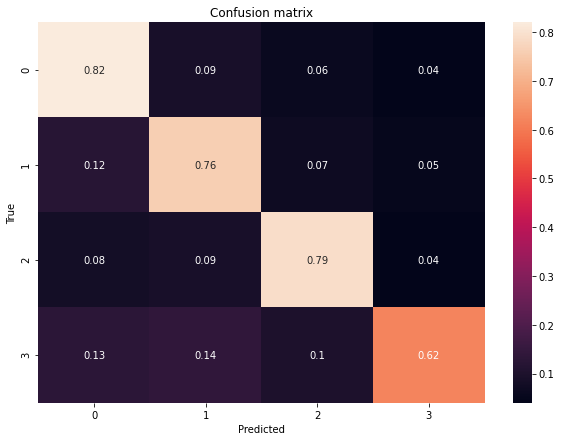

In [404]:
labels = range(4)
# labels.sort()

con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

df_cm = pd.DataFrame(con_mat_norm,
                     index = labels, 
                     columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [405]:
fig = go.Figure([go.Bar(x=X_train.columns, y=clf.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()

In [406]:
clf.get_depth()

24

In [407]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=X.columns,
#                    class_names='Środek transportu grupa',
#                    filled=True)

## All features, max_depth=10

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [409]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

komunikacja samochodowa       0.75      0.82      0.78      1178
   komunikacja zbiorowa       0.72      0.71      0.72       994
                 pieszo       0.74      0.74      0.74       895
                  rower       0.45      0.29      0.35       258

               accuracy                           0.72      3325
              macro avg       0.67      0.64      0.65      3325
           weighted avg       0.72      0.72      0.72      3325



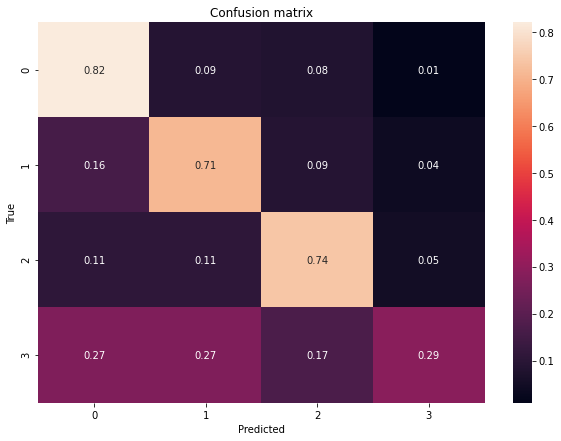

In [410]:
labels = range(4)
# labels.sort()

con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

df_cm = pd.DataFrame(con_mat_norm,
                     index = labels, 
                     columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [411]:
fig = go.Figure([go.Bar(x=X_train.columns, y=clf.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()

In [412]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=X.columns,
#                    class_names='Środek transportu grupa',
#                    filled=True)

# text_representation = tree.export_text(clf)
# print(text_representation)

### Selected features, max_depth=None

In [413]:
X.columns

Index(['Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?',
       'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?',
       'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?',
       'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej',
       'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką',
       'PIESZO Zły stan nawierzchni chodników',
       'PIESZO Zastawianie chodników przez parkujące samochody',
       'PIESZO Niebezpieczne zachowania kierowców',
       'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami',
       'PIESZO Zbyt wysokie krawężniki',
       'PIESZO Brak bieżącego utrzymania czystości/odśnieżania',
       'PIESZO Niewystarczająca liczba przejść dla pieszych',
       'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)',
       'PIESZO Uciążliwy ruch kołowy',
       'P

In [414]:
X['PIESZO-niedogodności'] = 0
for c in X.columns:
    if c.startswith('PIESZO '):
        X['PIESZO-niedogodności'] += X[c]

In [415]:
X['Liczba dzieci'] = X['Liczba osób w gospodarstwie domowym [ogółem]'] - X['Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]']

In [416]:
selected_cols = [
    'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?',
    'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?',
    'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?',
    'PIESZO-niedogodności',
    'Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]',
    'Liczba dzieci',
    'Przedział wiekowy',
    'Płeć',
    'Liczba aut w gosp. dom.',
    'Liczba rowerów w gosp. dom.',
    'Przebyta odległość'
]

subX = X[selected_cols]

In [417]:
X_train, X_test, y_train, y_test = train_test_split(subX, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [418]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

komunikacja samochodowa       0.83      0.86      0.84      1178
   komunikacja zbiorowa       0.82      0.79      0.80       994
                 pieszo       0.83      0.83      0.83       895
                  rower       0.66      0.68      0.67       258

               accuracy                           0.82      3325
              macro avg       0.79      0.79      0.79      3325
           weighted avg       0.82      0.82      0.82      3325



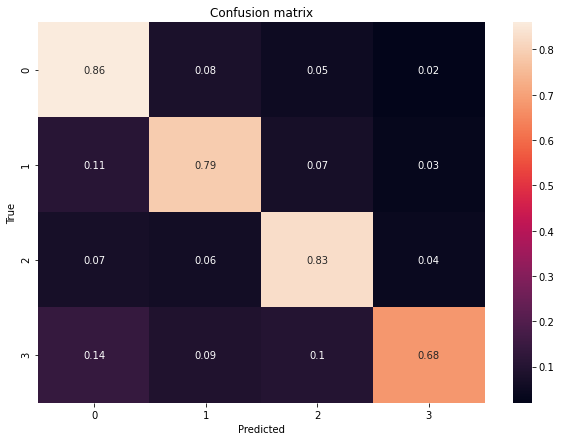

In [419]:
labels = range(4)
# labels.sort()

con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

df_cm = pd.DataFrame(con_mat_norm,
                     index = labels, 
                     columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [420]:
fig = go.Figure([go.Bar(x=X_train.columns, y=clf.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()

In [421]:
clf.get_depth()

25

### Selected columns, max_depth=20

In [422]:
selected_cols = [
    'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?',
    'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?',
    'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?',
    'PIESZO-niedogodności',
    'Liczba osób w gospodarstwie domowym [ogółem]',
    # 'Liczba dzieci',
    'Przedział wiekowy',
    # 'Płeć',
    'Liczba aut w gosp. dom.',
    'Liczba rowerów w gosp. dom.',
    'Przebyta odległość'
]

subX = X[selected_cols]

subX.columns = [
    'Ocena wygody jazdy komunikacją',
    'Ocena punktualności komunikacji',
    'Ocena systemu rowerowego',
    'Piesze niedogodności',
    'Liczba osób w gosp. dom.',
    # 'Liczba dzieci',
    'Przedział wiekowy',
    # 'Płeć',
    'Liczba aut w gosp. dom.',
    'Liczba rowerów w gosp. dom.',
    'Przebyta odległość'
]

In [423]:
X_train, X_test, y_train, y_test = train_test_split(subX, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier(random_state=42, max_depth=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [424]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

komunikacja samochodowa       0.82      0.87      0.84      1178
   komunikacja zbiorowa       0.84      0.77      0.81       994
                 pieszo       0.85      0.83      0.84       895
                  rower       0.62      0.70      0.66       258

               accuracy                           0.82      3325
              macro avg       0.78      0.79      0.79      3325
           weighted avg       0.82      0.82      0.82      3325



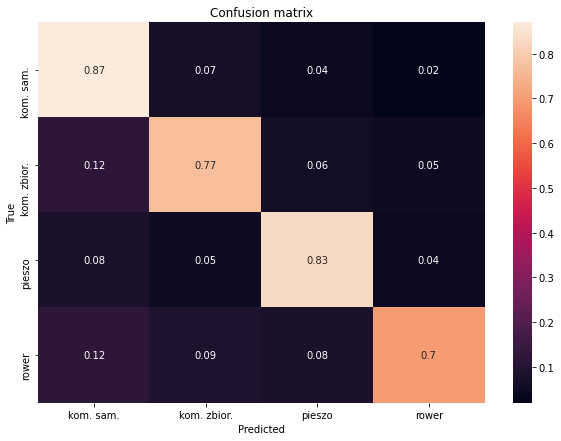

In [440]:
labels = range(4)
# labels.sort()

con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

df_cm = pd.DataFrame(con_mat_norm,
                     index = ['kom. sam.', 'kom. zbior.', 'pieszo', 'rower'], 
                     columns = ['kom. sam.', 'kom. zbior.', 'pieszo', 'rower'])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [426]:
fig = go.Figure([go.Bar(x=X_train.columns, y=clf.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()

In [427]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=X.columns,
#                    class_names='Środek transportu grupa',
#                    filled=True)

# # text_representation = tree.export_text(clf)
# # print(text_representation)

# Save Tree

In [428]:
# import pickle

In [429]:
# with open('./tree.pickle', 'wb') as f:
#     pickle.dump(clf, f)

# SHAP

In [430]:
import shap

In [431]:
explainer = shap.TreeExplainer(clf, model_output='probability', feature_dependence='independent', data=subX)

 96%|=================== | 38724/40300 [00:15<00:00]       

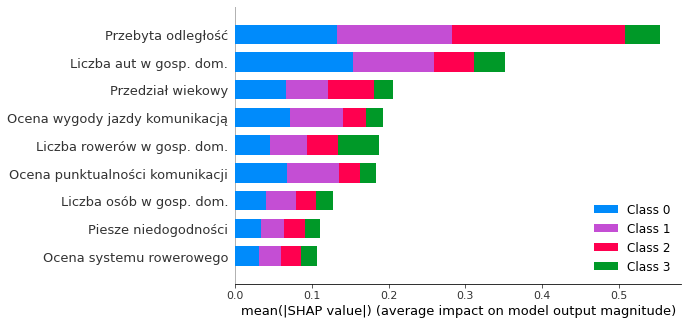

In [432]:
shap_values = explainer.shap_values(subX)
shap.summary_plot(shap_values, subX)

In [433]:
# subX['y_pred'] = clf.predict(subX)

In [434]:
# subX.head()

In [435]:
#Attempt to use SHAP on multi-class
X_rand = subX.sample(1, random_state=43)
# X_rand = subX[subX['y_pred'] == 1].sample(1, random_state=42)
idx = X_rand.index.values[0]

#This line will not work for a multi-class model, so we comment out
#explainer = shap.TreeExplainer(mcl, model_output='probability', feature_dependence='independent', data=X)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subX.iloc[idx])
shap.initjs()
for which_class in range(4):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))
    

In [436]:
clf.predict(X_rand)

array(['pieszo'], dtype=object)